#**Машинное обучение ИБ-2024**

#**Домашнее задание 2.**
#Классификация, KNN, LogReg, SVC.

In [2]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [3]:
def loss(X: np.array, y: np.array, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    N, K = X.shape
    z = np.dot(X, w) + w0
    log_loss = np.mean(np.log(1 + np.exp(-y * z)))
    l1_reg = gamma * np.sum(np.abs(w))
    l2_reg = beta * np.sum(w ** 2)
    total_loss = log_loss + l1_reg + l2_reg


#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [4]:
def get_grad(X: np.array, y: np.array, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:

    N, K = X.shape
    z = np.dot(X, w) + w0
    y_pred = 1 / (1 + np.exp(-z))
    error = y_pred - y
    grad_w = np.dot(X.T, error) / N
    grad_w0 = np.sum(error) / N
    grad_w += gamma * np.sign(w) + 2 * beta * w
    return grad_w.tolist(), grad_w0

In [5]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

AssertionError: 

####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [7]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state

    def fit(self, X, y):
        np.random.seed(self.random_state)
        N, K = X.shape
        self.w = np.random.randn(K)
        self.w0 = np.random.randn()

        for i in range(self.max_iter):
            grad_w, grad_w0 = get_grad(X, y, self.w, self.w0, self.gamma, self.beta)
            self.w -= self.lr * np.array(grad_w)
            self.w0 -= self.lr * grad_w0

            if np.linalg.norm(grad_w) < self.tolerance and np.abs(grad_w0) < self.tolerance:
                break

    def predict(self, X):
        z = np.dot(X, self.w) + self.w0
        y_pred = 1 / (1 + np.exp(-z))
        return (y_pred >= 0.5).astype(int)

    def predict_proba(self, X):
        z = np.dot(X, self.w) + self.w0
        y_pred = 1 / (1 + np.exp(-z))
        return np.vstack((1 - y_pred, y_pred)).T

In [8]:
# этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [9]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=100, linewidth=1, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary')
    plt.show()

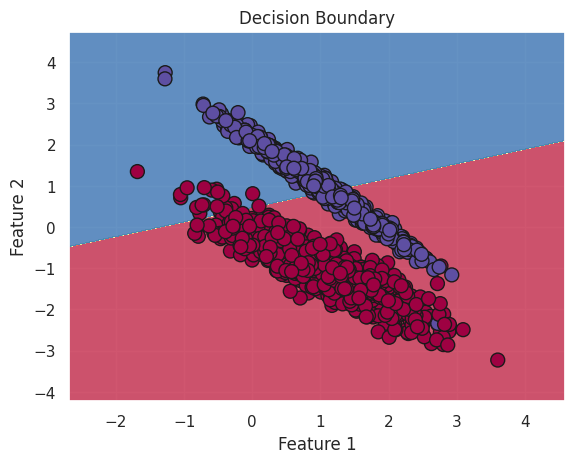

In [10]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

In [ ]:
def loss(X: np.array, y: np.array, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    N, K = X.shape
    z = np.dot(X, w) + w0
    log_loss = np.mean(np.log(1 + np.exp(-y * z)))
    l1_reg = gamma * np.sum(np.abs(w))
    l2_reg = beta * np.sum(w ** 2)
    total_loss = log_loss + l1_reg + l2_reg
    return total_loss
def get_grad(X: np.array, y: np.array, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    N, K = X.shape
    z = np.dot(X, w) + w0
    y_pred = 1 / (1 + np.exp(-z))
    error = y_pred - y
    grad_w = np.dot(X.T, error) / N
    grad_w0 = np.sum(error) / N
    grad_w += gamma * np.sign(w) + 2 * beta * w
    return grad_w.tolist(), grad_w0

class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.loss_history = []

    def fit(self, X, y):
        np.random.seed(self.random_state)
        N, K = X.shape
        self.w = np.random.randn(K)
        self.w0 = np.random.randn()

        for i in range(self.max_iter):
            grad_w, grad_w0 = get_grad(X, y, self.w, self.w0, self.gamma, self.beta)
            self.w -= self.lr * np.array(grad_w)
            self.w0 -= self.lr * grad_w0
            current_loss = loss(X, y, self.w, self.w0, self.gamma, self.beta)
            self.loss_history.append(current_loss)
            if np.linalg.norm(grad_w) < self.tolerance and np.abs(grad_w0) < self.tolerance:
                break

    def predict(self, X):
        z = np.dot(X, self.w) + self.w0
        y_pred = 1 / (1 + np.exp(-z))
        return (y_pred >= 0.5).astype(int)

    def predict_proba(self, X):
        z = np.dot(X, self.w) + self.w0
        y_pred = 1 / (1 + np.exp(-z))
        return np.vstack((1 - y_pred, y_pred)).T

In [ ]:
plot_loss_history(model)

#### 6. [2 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [ ]:
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2, random_state=42, n_clusters_per_class=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_prob)

    return acc, precision, recall, f1, auc_roc
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
C_values = [0.1, 1, 10, 100]
results = []
for kernel in kernels:
    for C in C_values:
        model = SVC(kernel=kernel, C=C, probability=True, random_state=42)
        model.fit(X_train, y_train)
        acc, precision, recall, f1, auc_roc = evaluate_model(model, X_test, y_test)
        results.append({
            'Kernel': kernel,
            'C': C,
            'Accuracy': acc,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC-ROC': auc_roc
        })
results_df = pd.DataFrame(results)
print(results_df)
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x='C', y='Accuracy', hue='Kernel', marker='o')
plt.title('Accuracy for Different Kernels and C Values')
plt.xscale('log')
plt.show()
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x='C', y='Precision', hue='Kernel', marker='o')
plt.title('Precision for Different Kernels and C Values')
plt.xscale('log')
plt.show()
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x='C', y='Recall', hue='Kernel', marker='o')
plt.title('Recall for Different Kernels and C Values')
plt.xscale('log')
plt.show()
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x='C', y='F1-Score', hue='Kernel', marker='o')
plt.title('F1-Score for Different Kernels and C Values')
plt.xscale('log')
plt.show()
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x='C', y='AUC-ROC', hue='Kernel', marker='o')
plt.title('AUC-ROC for Different Kernels and C Values')
plt.xscale('log')
plt.show()

#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [ ]:
import numpy as np
from scipy.spatial import distance
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import pandas as pd
class KNNClassifier:
    def __init__(self, n_neighbors=5, metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.metric = metric
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.classes = np.unique(y)
    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)
    def predict_proba(self, X):
        proba = []
        for x in X:
            distances = [distance.euclidean(x, x_train) for x_train in self.X_train]
            k_indices = np.argsort(distances)[:self.n_neighbors]
            k_nearest_labels = self.y_train[k_indices]
            proba.append([np.mean(k_nearest_labels == c) for c in self.classes])
        return np.array(proba)
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_prob)

    return acc, precision, recall, f1, auc_roc
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                           random_state=42, n_clusters_per_class=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = KNNClassifier(n_neighbors=5, metric='euclidean')
model.fit(X_train, y_train)
acc, precision, recall, f1, auc_roc = evaluate_model(model, X_test, y_test)
print(f"Accuracy: {acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"AUC-ROC: {auc_roc}")

## **Практическая часть**

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

#### 8. [0 Балл] Импортируйте датафрейм из csv файла. Поделите выборку следующим образом - :50000 (Train) и 50000: (Test).

In [ ]:
data = pd.read_csv('train.csv')
X = data.drop('label', axis=1)
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
print(f"Train set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

In [ ]:
import matplotlib.pyplot as plt
data = pd.read_csv('fashion-mnist_train.csv')
X = data.drop('label', axis=1)
y = data['label']
classes = y.unique()
fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))
for i, cls in enumerate(classes):
    idx = y[y == cls].index[0]
    image = X.iloc[idx].values.reshape(28, 28)
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f'Class {cls}')
    axes[i].axis('off')
plt.show()

#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
data = pd.read_csv('train.csv')
X = data.drop('label', axis=1)
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
scaler_standard = StandardScaler()
X_train_standard = scaler_standard.fit_transform(X_train)
X_test_standard = scaler_standard.transform(X_test)
scaler_minmax = MinMaxScaler()
X_train_minmax = scaler_minmax.fit_transform(X_train)
X_test_minmax = scaler_minmax.transform(X_test)



#### 10. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

**NB!**: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
data = pd.read_csv('fashion-mnist_train.csv')
X = data.drop('label', axis=1)
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
knn = KNeighborsClassifier()
knn_grid_search = GridSearchCV(knn, knn_param_grid, cv=5, scoring='accuracy')
knn_grid_search.fit(X_train, y_train)
logreg_param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga', 'lbfgs'],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'max_iter': [100, 200, 300]
}
logreg = LogisticRegression()
logreg_grid_search = GridSearchCV(logreg, logreg_param_grid, cv=5, scoring='accuracy')
logreg_grid_search.fit(X_train, y_train)
knn_best = knn_grid_search.best_estimator_
logreg_best = logreg_grid_search.best_estimator_

knn_accuracy = accuracy_score(y_test, knn_best.predict(X_test))
logreg_accuracy = accuracy_score(y_test, logreg_best.predict(X_test))

print(f"Best KNN Parameters: {knn_grid_search.best_params_}")
print(f"KNN Accuracy: {knn_accuracy}")

print(f"Best Logistic Regression Parameters: {logreg_grid_search.best_params_}")
print(f"Logistic Regression Accuracy: {logreg_accuracy}")
if knn_accuracy > logreg_accuracy:
    print("KNN показывает лучшее качество.")
else:
    print("Logistic Regression показывает лучшее качество.")

## **Бонусы**

#### Задача 1. [1 Балл] У Вас есть датасет с 10**4 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.

#### Задача 2. [1 Балл] При классификации Fashion Mnist модель Логистической регрессии на обучении многоклассовой классификации методом One-VS-All у Вас получилось k классификаторов. Изобразите веса ваших полученных моделей как изображения в matplotlib. Возможно, модель выучила какие-то графические паттерны в данных? Ответ обоснуйте.

#### Задача 3. [1 Балл] В задаче классификации Fashion Mnist Вы попытались выбить какой-то accuracy. Для получения бонусного балла Вам нужно на той же самой выборке получить значение метрики accuracy > 0.87 на тесте (Тестовую выборку менять нельзя, но обучающую можно). Какими моделями и методами Вы это будете делать - на Ваше усмотрение, но **нельзя использовать никакие нейронные сети**. Необходимо получить модель машинного обучения, выполняющую эту задачу.

1) Все объекты в наборе данных обладают идентичными значениями признаков. Это указывает на отсутствие информации, способной помочь модели различать объекты разных классов.
Логистическая регрессия применяет линейную комбинацию признаков для оценки вероятностей классов. Если все признаки одинаковы, то линейная комбинация будет одинаковой для всех объектов.
SGD обновляет веса модели на каждой итерации, основываясь на градиентах функции потерь. Если все объекты имеют одинаковые признаки, градиенты будут идентичными для всех объектов, что не позволит модели выявить различия между классами. В результате обучения модель будет предсказывать вероятности классов, равные 0.5 для каждого объекта. Это свидетельствует о том, что модель не в состоянии различать классы и будет делать случайные предсказания.